In [1]:
!pip install keras-tuner

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D

from keras.utils import plot_model
from keras import regularizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras import layers

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import pickle

In [16]:
%load_ext autotime
RANDOM_STATE = 42

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 948 µs


In [4]:
seed = 7
np.random.seed(seed)

time: 72.8 ms


In [5]:
MEMORY_LIMIT = 4500
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_LIMIT)])
    except RuntimeError as e:
        print(e)

time: 148 ms


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

time: 84.8 ms


In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

time: 615 ms


In [8]:
tf.test.is_built_with_cuda()

True

time: 50.8 ms


In [17]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder+'/'+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    #print(f"Image shape {img.shape}")
    return img

time: 1.43 ms


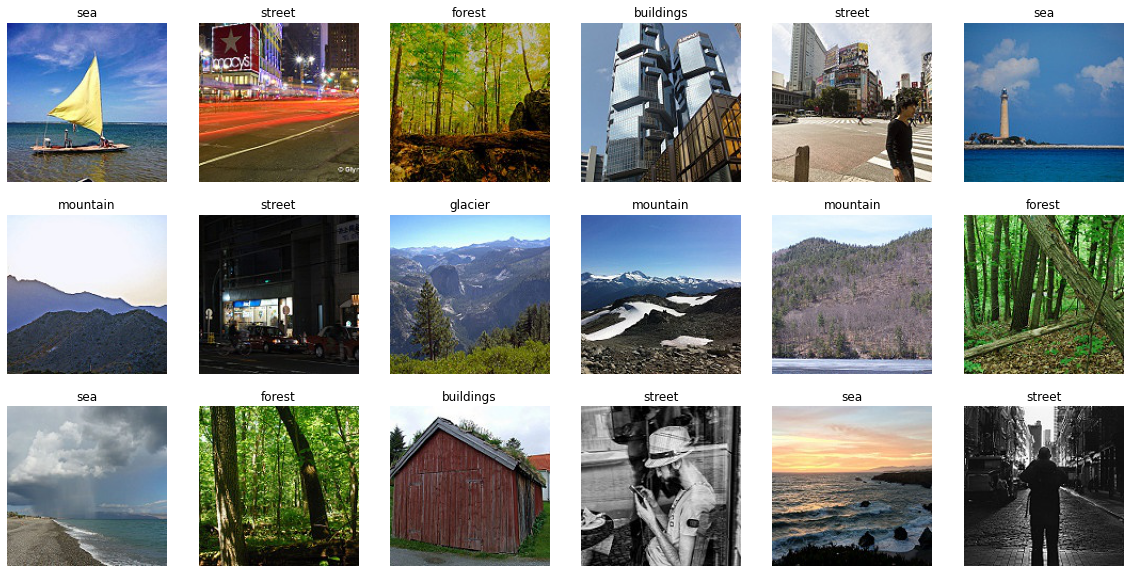

time: 929 ms


In [18]:
import random
import matplotlib.image as mpimg
from pathlib import Path
import os.path
class_names=['buildings', 'forest', 'glacier', 'mountain' ,'sea' ,'street']
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir='/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/',target_class=class_name)

In [19]:
train_dir = "/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/"
test_dir = "/home/anjir29/Desktop/America/data/archive/seg_test/seg_test/"
val_dir ="/home/anjir29/Desktop/America/data/archive/seg_val/seg_test/"

time: 802 µs


In [20]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1./255)

training_data = train_data.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (32,32), 
                                              class_mode = 'categorical')

val_data = ImageDataGenerator(rescale = 1./255)

validation_data = val_data.flow_from_directory(val_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')


test_data = ImageDataGenerator(rescale = 1./255)

testing_data = test_data.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
time: 549 ms


In [21]:
LOG_DIR = f"{int(time.time())}"

time: 540 µs


In [22]:
def build_model(hp):

    model = Sequential()
    model.add(Conv2D(hp.Choice('layer_size_1', values=[16,32,64,128,256,512],default=16), 3, padding = 'same',input_shape=(32, 32,3),activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu', 'tanh', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_1', values=[16,32,64,128,256,512],default=16), 3, activation=hp.Choice('activation_1',values=['relu', 'elu', 'gelu', 'selu'],default='relu'), padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    #####################################Block 2#################################         
    model.add(Conv2D(hp.Choice('layer_size_2', values=[16,32,64,128,256,512],default=16), 3,padding ='same', activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_2', values=[16,32,64,128,256,512],default=16), 3,padding ='same', activation=hp.Choice('activation_2',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 3#################################            
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_3',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_3', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same',))
    model.add(Dropout(hp.Choice('dp_size_3', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_3', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_3',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 4################################
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_4', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_4', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_4', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_4',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ######################################Block 5#################################
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_5', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(Dropout(hp.Choice('dp_size_5', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Conv2D(hp.Choice('layer_size_5', values=[16,32,64,128,256,512],default=16), 3, padding = 'same', activation=hp.Choice('activation_5',values=['relu', 'elu', 'gelu', 'selu'],default='relu')))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    ############################################################################
    model.add(Dropout(hp.Choice('dp_size_6', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Flatten())
    model.add(Dense(hp.Choice('dense_size_1', values=[64,128,256,512],default=64),activation=hp.Choice('activation_dense',values=['relu', 'elu', 'gelu', 'selu'],default='relu'),kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
    model.add(Dense(hp.Choice('dense_size_2', values=[64,128,256,512],default=64),activation=hp.Choice('activation_dense',values=['relu', 'elu', 'gelu', 'selu'],default='relu'),kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0))))
    model.add(Dropout(hp.Choice('dp_size_7', values=[0.0,0.1,0.2,0.3,0.4,0.5],default=0.0)))
    model.add(Dense(units=6, activation="softmax"))
 ##############################################################################           
    
    opt = Adam(lr=hp.Choice('learning_rate', values=[0.1,0.01, 0.001, 0.0001],default=0.01))
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                                  optimizer=opt,
                                                  metrics=['accuracy'])
    return model

time: 11.3 ms


In [23]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR,
    project_name='BS_Vgg16_Intel')

time: 332 ms


In [15]:
tuner.search_space_summary()
my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
tuner.search(training_data,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=30,
             batch_size=64,
             callbacks=[my_callbacks],  # if you have callbacks like tensorboard, they go here.
             validation_data=validation_data)

tuner.results_summary()

with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

Trial 20 Complete [00h 12m 47s]
val_accuracy: 0.8141666650772095

Best val_accuracy So Far: 0.8462499976158142
Total elapsed time: 03h 16m 27s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1624285554/BS_Vgg16_Intel
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
layer_size_1: 512
activation_2: relu
dp_size_1: 0.0
activation_1: relu
layer_size_2: 512
dp_size_2: 0.5
layer_size_3: 128
activation_3: selu
dp_size_3: 0.0
layer_size_4: 16
activation_4: relu
dp_size_4: 0.2
layer_size_5: 512
activation_5: elu
dp_size_5: 0.0
dp_size_6: 0.2
dense_size_1: 64
activation_dense: selu
wd_size_1: 0.1
dense_size_2: 128
dp_size_7: 0.0
learning_rate: 0.0001
Score: 0.8462499976158142
Trial summary
Hyperparameters:
layer_size_1: 512
activation_2: selu
dp_size_1: 0.0
activation_1: relu
layer_size_2: 256
dp_size_2: 0.5
layer_size_3: 32
activation_3: selu
dp_size_3: 0.2
layer_size_4: 64
activation_4: relu
dp_size_4: 0.1
layer_size_5: 512


In [24]:
with open("tuner_1624344753.pkl", "rb") as f:
    tuner_new = pickle.load(f)

time: 7.82 ms


In [25]:
new_model = tuner_new.get_best_hyperparameters()[0]

time: 687 µs


In [26]:
model = tuner.hypermodel.build(new_model)

time: 265 ms


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 512)       14336     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 512)       2359808   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       5

In [19]:
hist=model.fit(training_data,
      batch_size=64,
      epochs=100,
      validation_data=validation_data,
      callbacks=[my_callbacks])

Epoch 1/100
439/439 [==============================] - 47s 104ms/step - loss: 17.1069 - accuracy: 0.3522 - val_loss: 8.1564 - val_accuracy: 0.6017
Epoch 2/100
439/439 [==============================] - 45s 103ms/step - loss: 6.7233 - accuracy: 0.5949 - val_loss: 3.5944 - val_accuracy: 0.6654
Epoch 3/100
439/439 [==============================] - 47s 106ms/step - loss: 3.0665 - accuracy: 0.6645 - val_loss: 1.8707 - val_accuracy: 0.7113
Epoch 4/100
439/439 [==============================] - 47s 107ms/step - loss: 1.6891 - accuracy: 0.7023 - val_loss: 1.1776 - val_accuracy: 0.7608
Epoch 5/100
439/439 [==============================] - 47s 107ms/step - loss: 1.1112 - accuracy: 0.7471 - val_loss: 0.8431 - val_accuracy: 0.7837
Epoch 6/100
439/439 [==============================] - 47s 108ms/step - loss: 0.8427 - accuracy: 0.7761 - val_loss: 0.6972 - val_accuracy: 0.8033
Epoch 7/100
439/439 [==============================] - 46s 106ms/step - loss: 0.6984 - accuracy: 0.7993 - val_loss: 0.6111 

In [36]:
_,test_acc = model.evaluate(testing_data[0][0],testing_data[0][1])

1/1 [==============================] - 0s 44ms/step - loss: 1.8026 - accuracy: 0.1562
time: 112 ms
